/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 145MB/s]
/tmp/ipykernel_17/951056095.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value

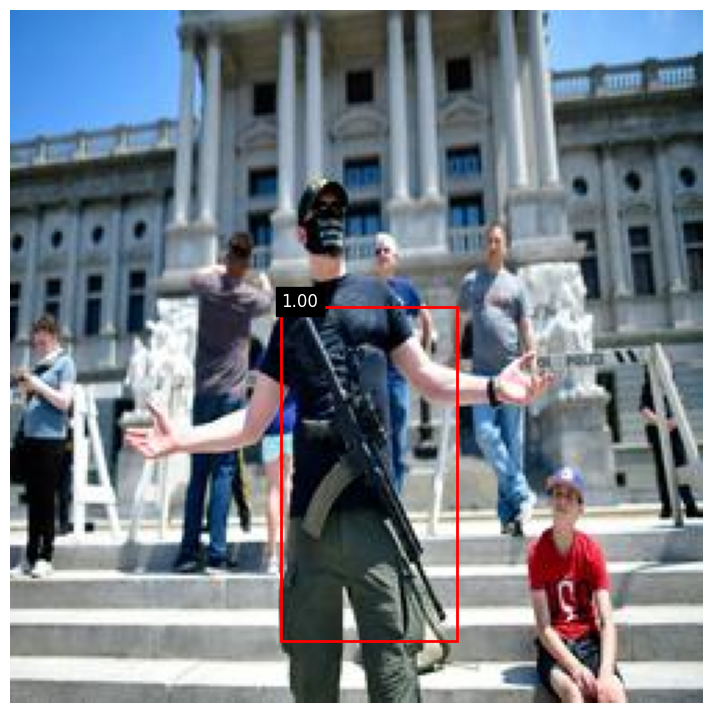

In [1]:
import cv2
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T

class HarmfulObjectDataset(Dataset):
    def __init__(self, imgs_path, labels_path, transforms=None):
        self.imgs_path = imgs_path
        self.labels_path = labels_path
        self.transforms = transforms
        
        self.img_names = [img for img in sorted(os.listdir(self.imgs_path)) if img.endswith(('.jpg', '.png', '.jpeg'))]
        self.label_names = [label for label in sorted(os.listdir(self.labels_path)) if label.endswith('.txt')]
        
        self.img_names = [img for img in self.img_names if self._get_label_file(img)]

    def _get_label_file(self, img_name):
        base_name = img_name.rsplit('.', 1)[0]
        label_file = f"{base_name}.txt"
        return label_file if label_file in self.label_names else None

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.imgs_path, img_name)
        label_file = self._get_label_file(img_name)
        label_path = os.path.join(self.labels_path, label_file)
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_rgb /= 255.0
        
        if self.transforms:
            img_rgb = self.transforms(img_rgb)
        
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            label = int(line[0])
            x_center, y_center, width, height = map(float, line[1:])
        
        img_height, img_width = img_rgb.shape[1], img_rgb.shape[2]
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        x_max = (x_center + width / 2) * img_width
        y_max = (y_center + height / 2) * img_height

        # Ensure boxes have positive width and height
        if x_min >= x_max or y_min >= y_max:
            raise ValueError(f"Invalid bounding box: ({x_min}, {y_min}, {x_max}, {y_max})")
        
        boxes = torch.as_tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32)
        labels = torch.as_tensor([label], dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        return img_rgb, target

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def make_predictions(model, image, device):
    model.eval()
    with torch.no_grad():
        prediction = model(image)
    return prediction[0]

def plot_prediction(image, prediction, threshold=0.5):
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    img_np = np.array(image)
    
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_np)
    
    for i, (box, score) in enumerate(zip(boxes, scores)):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 edgecolor='r', facecolor='none', linewidth=2)
            ax.add_patch(rect)
            ax.text(x_min, y_min, f'{score:.2f}', color='white', fontsize=12, backgroundcolor='black')
    
    plt.axis('off')
    plt.show()

def main(image_path, model_path):
    device = torch.device("cpu")  # Set to CPU explicitly

    # Load model
    num_classes = 5  # Change according to your number of classes
    model = get_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load model on CPU
    model.to(device)

    # Prepare image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    img_tensor = T.ToTensor()(img_rgb).unsqueeze(0).to(device)

    # Make predictions
    prediction = make_predictions(model, img_tensor, device)

    # Plot results
    plot_prediction(img_rgb, prediction)

if __name__ == "__main__":
    # Specify the path to your image and the trained model
    image_path = '/kaggle/input/small-hod/HOD/Images/Rifle/image 11.jpg'  # Change this to your image path
    model_path = '/kaggle/input/hod-new-model/harmful_object_detector.pth'  # Path to your trained model

    main(image_path, model_path)
